In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
filepath = '../data/cell_tracks/'

### To do 
1. Make the file loading procedure generic 
2. Create functions which load the correct csv file, without repeated calls 
3. Have a dictionary or file which holds all the wound locations 
4. Rename dataframes to make sense (this will get captured in creating sensible functions)
5. Make sure data is saved to correct location 

## This is the preprocessing pipeline for both the macrophage cell tracks 
The below code should preprocess the data before it is ready to be run in the inference pipeline. It does this by the following steps:
1. Loads the csv files holding the cell tracking data
2. Cleans the data on the quality of the cell tracks 
3. Cleans the data dependent on the average length of the cell tracks (i.e. how may timepoints they have)
4. Removes any cell tracks which are outside of the main body of the pupae of the fly 
7. Saves a new csv file which contains the filtered cell tracks for later use in inference pipeline  


In [34]:
# load Macrophage cell tracks
# Control 
df_c1 = pd.read_csv(filepath+'Single_wound/Control/Control 1.csv')  
df_c2 = pd.read_csv(filepath+'Single_wound/Control/Control 2.csv')  
df_c3 = pd.read_csv(filepath+'Single_wound/Control/Control 3.csv') 
df_c4 = pd.read_csv(filepath+'Single_wound/Control/Control 4.csv') 
df_c5 = pd.read_csv(filepath+'Single_wound/Control/Control 5.csv') 
df_c6 = pd.read_csv(filepath+'Single_wound/Control/Control 6.csv') 

# MCR 
df_mcr1 = pd.read_csv(filepath+'Single_wound/MCR/MCR 1.csv')
df_mcr2 = pd.read_csv(filepath+'Single_wound/MCR/MCR 2.csv')
df_mcr3 = pd.read_csv(filepath+'Single_wound/MCR/MCR 3.csv')
df_mcr4 = pd.read_csv(filepath+'Single_wound/MCR/MCR 4.csv')

# MCR half wound 
df_h1 = pd.read_csv(filepath+'Half_wound/MCR_H1.csv')
df_h2 = pd.read_csv(filepath+'Half_wound/MCR_H2.csv')
df_h3 = pd.read_csv(filepath+'Half_wound/MCR_H3.csv')
df_h4 = pd.read_csv(filepath+'Half_wound/MCR_H4.csv')

# Two wounds 
df_2c1 = pd.read_csv(filepath+'Two_wound_data/Control/Control_001.csv')  
df_2c2 = pd.read_csv(filepath+'Two_wound_data/Control/Control_002.csv')  
df_2c3 = pd.read_csv(filepath+'Two_wound_data/Control/Control_003.csv') 
df_2mcr1 = pd.read_csv(filepath+'Two_wound_data/MCR/MCR 001.csv')
df_2mcr2 = pd.read_csv(filepath+'Two_wound_data/MCR/MCR 002.csv')
df_2mcr3 = pd.read_csv(filepath+'Two_wound_data/MCR/MCR 004.csv')
df_2mcr4 = pd.read_csv(filepath+'Two_wound_data/MCR/MCR 005.csv')

In [35]:
#list of data frames
list_dfs = [df_c1, df_c2, df_c3, df_c4, df_c5, df_c6, df_mcr1, df_mcr2, df_mcr3, df_mcr4, df_h1, df_h2, df_h3, df_h4, 
            df_2c1, df_2c2, df_2c3, df_2mcr1, df_2mcr2, df_2mcr3, df_2mcr4]

In [36]:
# count number of unique tracks
for i, this_df in enumerate(list_dfs):
    print(i, this_df['TRACK_ID'].nunique())

0 183
1 152
2 213
3 297
4 345
5 110
6 82
7 32
8 67
9 44
10 65
11 108
12 56
13 52
14 136
15 96
16 118
17 41
18 68
19 135
20 129


## First we need to clean up the dataframe and then analyse cell track lengths

In [37]:
# Preprocessing dataframe to make it cleaner to use 
def preprocess(df):
    df.drop(['Label', 'ID',
       'POSITION_Z','FRAME', 'RADIUS', 'VISIBILITY',
       'MANUAL_COLOR', 'MEAN_INTENSITY', 'MEDIAN_INTENSITY', 'MIN_INTENSITY',
       'MAX_INTENSITY', 'TOTAL_INTENSITY', 'STANDARD_DEVIATION',
       'ESTIMATED_DIAMETER', 'CONTRAST', 'SNR'], axis = 1 ,inplace = True)
    return df # not needed if modified in place

# This function takes in our new dataframe without the FBC linked tracks, cleans up the labelling of the columns and renormalises the tracks so the wound is at 0,0. It also adds a label to the 
# Track_ID so we can keep track of which track belongs to which original dataframe. This is important for running the inference pipeline later. 
def centre_at_zero(df,xw,yw,label):
    reshapeddata = pd.DataFrame({'Track_ID':df['TRACK_ID'],
                             't':df['POSITION_T'],
                             'x':df['POSITION_X'],
                             'y':df['POSITION_Y']})    
    reshapeddata['x'] = reshapeddata['x'] - xw
    reshapeddata['y'] = reshapeddata['y'] - yw
    reshapeddata['r'] = (lambda x, y: np.sqrt(x ** 2 + y ** 2))(reshapeddata['x'], reshapeddata['y'])
    theta = -np.pi / 4
    rotation_matrix = np.array([[np.cos(theta), np.sin(theta)],
                            [-np.sin(theta), np.cos(theta)]])

    # Apply the rotation to the DataFrame
    rotated_coordinates = np.dot(reshapeddata[['x', 'y']], rotation_matrix.T)

    # Update the DataFrame with rotated coordinates
    reshapeddata[['rotate-x', 'rotate-y']] = rotated_coordinates
    reshapeddata['theta'] = np.arctan2(reshapeddata['rotate-y'], reshapeddata['rotate-x'])

    reshapeddata['Track_ID'] = reshapeddata['Track_ID'].astype(str)
    reshapeddata.Track_ID = reshapeddata.Track_ID + "{}".format(label)  # creates a label for the tracks to be organised by
    return reshapeddata

In [38]:
list_dfs_filtered = []
for i, this_df in enumerate(list_dfs):
    filtered_df = preprocess(this_df)
    # adjust y position to Python standard from ImageJ 
    filtered_df['POSITION_Y'] = 565.688 - filtered_df['POSITION_Y'] 
    list_dfs_filtered.append(filtered_df)

[       TRACK_ID  QUALITY  POSITION_X  POSITION_Y  POSITION_T
 0             8   99.066     153.198     401.248       0.000
 1             8   99.464     152.832     401.471      29.931
 2             8  110.222     152.663     401.626      59.862
 3             8  100.765     152.670     400.393      89.793
 4             8  103.786     154.398     401.049     119.724
 ...         ...      ...         ...         ...         ...
 25509      1441   94.783     177.249     276.612   10625.505
 25510      1441   83.106     177.423     279.466   10655.436
 25511      1441   94.107     179.569     280.809   10685.367
 25512      1441   92.276     181.560     278.629   10715.298
 25513      1441   84.640     182.885     277.328   10745.229
 
 [25514 rows x 5 columns],
        TRACK_ID  QUALITY  POSITION_X  POSITION_Y  POSITION_T
 0             2  109.632     501.470      30.551       0.000
 1             2  110.372     500.274      30.153      29.931
 2             2  107.906     499.041    

In [25]:
# MCR 
#df_1 = centre_at_zero(filtered_df_1,252,(565.688-321), "B")
#df_2 = centre_at_zero(filtered_df_2,247,(565.688-315), "C")
#df_3 = centre_at_zero(filtered_df_3,240,(565.688-364), "D")
#df_4 = centre_at_zero(filtered_df_4,235,(565.688-339), "E")
#df_h1 = centre_at_zero(filtered_df_h1,303,(565.688-260), "A")
#df_h2 = centre_at_zero(filtered_df_h2,276,(565.688-317), "B")
#df_h3 = centre_at_zero(filtered_df_h3,263,(565.688-292), "C")
#df_h4 = centre_at_zero(filtered_df_h4,296,(565.688-323), "D")

In [26]:
# Control
# df_1 = centre_at_zero(filtered_df_1,231,(565.688-341), "B")
#df_2 = centre_at_zero(filtered_df_2,245,(565.688-323), "C")
#df_3 = centre_at_zero(filtered_df_3,263,(565.688-349), "D")
#df_4 = centre_at_zero(filtered_df_4,235,(565.688-322), "E")
# df_5 = centre_at_zero(filtered_df_5,242,(565.688-265), "F")
#df_6 = centre_at_zero(filtered_df_6,281,(565.688-333), "G")



In [7]:
# df_1['t'] = df_1['t'].div(60) # Reset times to minutes
#df_2['t'] = df_2['t'].div(60)
#df_3['t'] = df_3['t'].div(60)
#df_4['t'] = df_4['t'].div(60)
# df_5['t'] = df_5['t'].div(60)
#df_6['t'] = df_6['t'].div(60)

#df_h1['t'] = df_h1['t'].div(60)
#df_h2['t'] = df_h2['t'].div(60)
#df_h3['t'] = df_h3['t'].div(60)
#df_h4['t'] = df_h4['t'].div(60)

NameError: name 'df_5' is not defined

In [28]:
# Create a new dataframe with all the macrophage tracking data
#McList = [df_1,df_2,df_3,df_4]#,df_5,df_6]
#total_cells = pd.concat(McList).reset_index()
#total_cells
#print(total_cells.dtypes, )
#

In [29]:
# Save the data to csv for processing the Inference pipeline
#total_cells.to_csv("/Users/danieltudor/Desktop/Wood group/New Images from Luigi/Videos/MCR_filtered_spots_all_new")

## Plots the cell tracks 

Plot the cell tracks to make sure they are orientated the correct way and with good coverage for the inference 

In [30]:
from matplotlib.patches import Circle

KeyError: 'Track_ID'

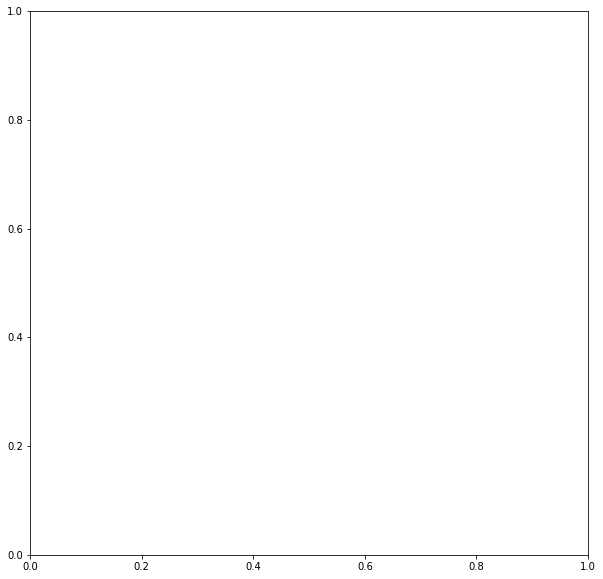

In [8]:
fig, ax = plt.subplots(figsize=(10, 10))
total_cells = df5
for track_id in total_cells['Track_ID'].unique():
    # get the x and y coordinates for the current track
    x = total_cells[total_cells['Track_ID'] == track_id]['x']
    y = total_cells[total_cells['Track_ID'] == track_id]['y']
    # plot the track as a line
    ax.plot(x, y)
# add axis labels and legend
circ1 = Circle((0,0), 16, facecolor='None', edgecolor='k', lw=3, alpha = 1)
ax.add_patch(circ1)
ax.set_xlabel('X Position ($\mu$m)')
ax.set_ylabel('Y Position ($\mu$m)')
plt.savefig("Control Cell tracking.pdf")
plt.show()

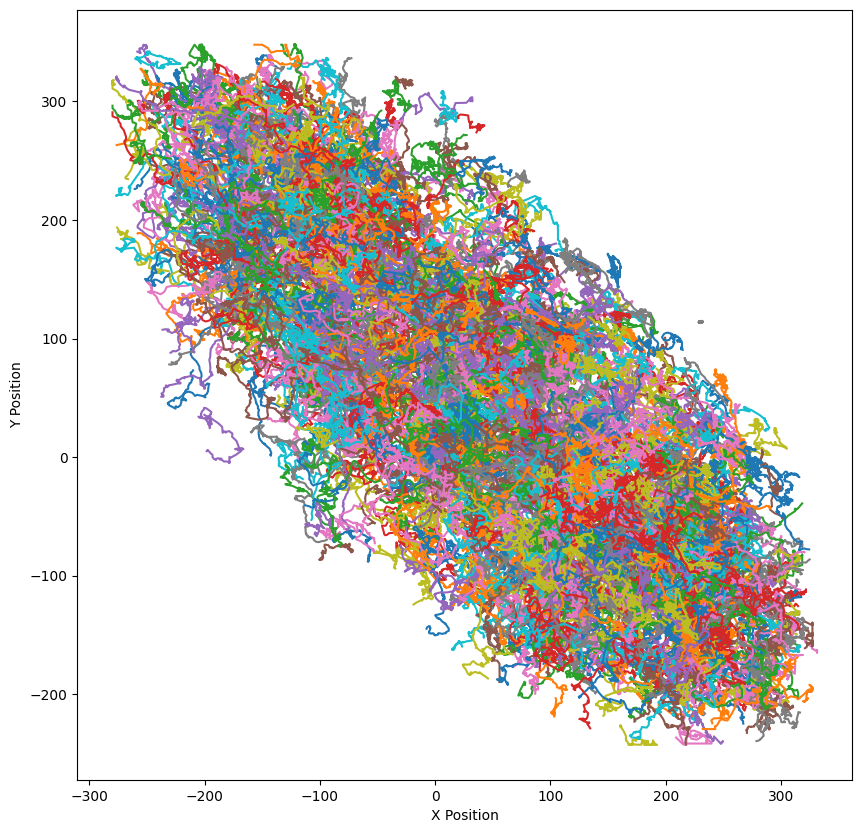

In [12]:
fig, ax = plt.subplots(figsize=(10, 10))
for track_id in total_cells['Track_ID'].unique():
    # get the x and y coordinates for the current track
    x = total_cells[total_cells['Track_ID'] == track_id]['x']
    y = total_cells[total_cells['Track_ID'] == track_id]['y']
    # plot the track as a line
    ax.plot(x, y)
# add axis labels and legend
ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
plt.show()

In [13]:
total_cells

,index,Track_ID,t,x,y,r,rotate-x,rotate-y,theta
0,0,1A,0.0,-139.426,209.211,251.413707,-246.523587,49.345447,2.944038
1,1,1A,0.5,-139.766,208.673,251.155242,-246.383580,48.724607,2.946353
2,2,1A,1.0,-139.412,208.315,250.660817,-245.880120,48.721779,2.945974
3,3,1A,1.5,-139.425,209.136,251.350745,-246.469847,49.293121,2.944200
4,4,1A,2.0,-138.852,209.672,251.480070,-246.443684,50.077302,2.941122
...,...,...,...,...,...,...,...,...,...
144918,50085,2081D,177.5,34.823,110.401,115.762784,-53.441716,102.688875,2.050649
144919,50086,2081D,178.0,35.221,110.669,116.138479,-53.349792,103.159808,2.048075
144920,50087,2081D,178.5,35.728,110.727,116.348436,-53.032301,103.559324,2.044074
144921,50088,2081D,179.0,35.742,110.536,116.170985,-52.887345,103.434166,2.043454


In [14]:
def angle_binning(trajectory):
        theta_pos = trajectory[(trajectory['theta'] >= 0)]
        theta_neg = trajectory[(trajectory['theta'] < 0)]

        return [theta_pos, theta_neg]

In [15]:
angles = angle_binning(total_cells)

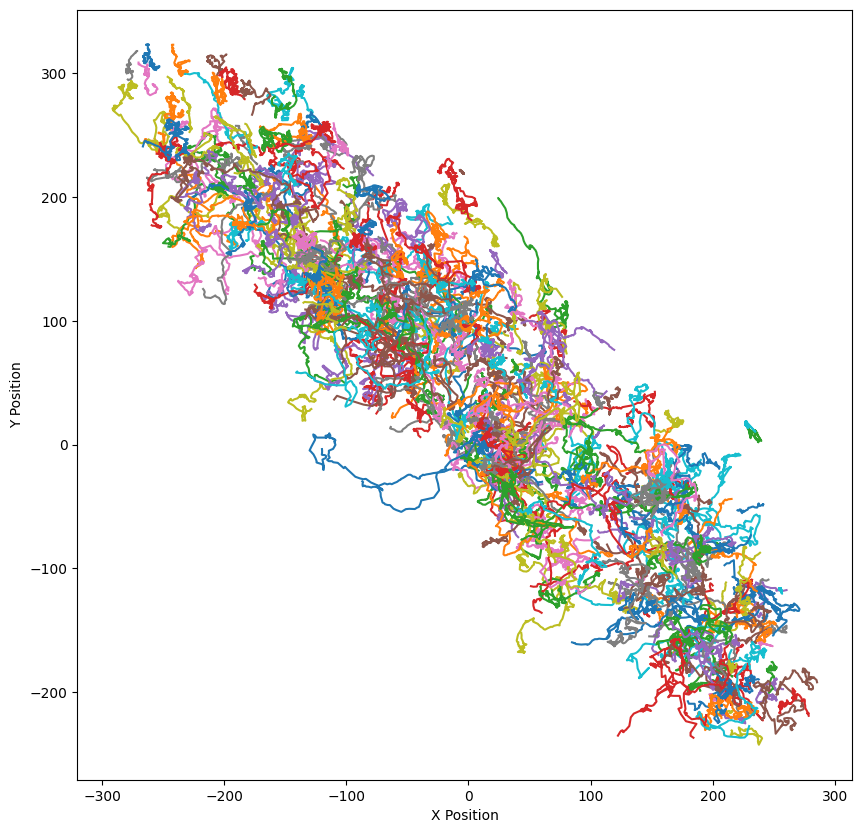

In [16]:
fig, ax = plt.subplots(figsize=(10, 10))
for track_id in angles[0]['Track_ID'].unique():
    # get the x and y coordinates for the current track
    x = total_cells[total_cells['Track_ID'] == track_id]['x']
    y = total_cells[total_cells['Track_ID'] == track_id]['y']
    # plot the track as a line
    ax.plot(x, y)
# add axis labels and legend
ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
plt.show()

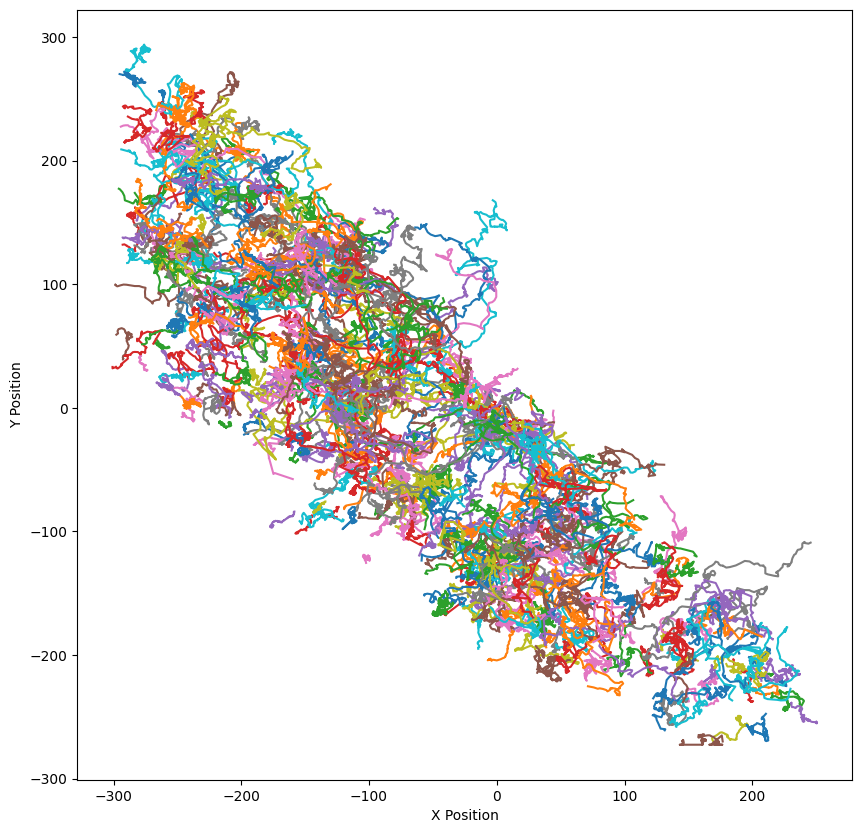

In [17]:
fig, ax = plt.subplots(figsize=(10, 10))
for track_id in angles[1]['Track_ID'].unique():
    # get the x and y coordinates for the current track
    x = total_cells[total_cells['Track_ID'] == track_id]['x']
    y = total_cells[total_cells['Track_ID'] == track_id]['y']
    # plot the track as a line
    ax.plot(x, y)
# add axis labels and legend
ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
plt.show()